In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os

plt.rcParams['svg.fonttype'] = 'none'

In [1]:
from imports import *

In [2]:
def filter_corr_matrix(corr,regions,types,metadata):
    if isinstance(regions,str):
        regions = (regions,regions)
    if isinstance(types,str):
        types = (types,types)
    return corr[(metadata.Region == regions[0]) & (metadata.Type == types[0])][:,(metadata.Region == regions[1]) & (metadata.Type == types[1])]

# Here we are going to compare the synchrony of neurons in the BLA (mainly) during NREM and REM sleep
## Examples 
First part of the code will produce a figure that show corr matrix of neurons in Hpc and BLA during NREM REM and wake_homecage

In [9]:
bk.load.current_session_linux(local_path='Rat08/Rat08-20130713')
states = bk.load.states(True)
states.pop('drowsy')
states.pop('wake')
neurons, metadata = bk.load.spikes()

actmat_ = bk.compute.binSpikes(neurons,as_Tsd=True)
actmat = {}
for state,interval in states.items():
    actmat.update({state:actmat_.restrict(interval)})

corrmatrix = {}
for state in states:
    corrmatrix.update({state:np.corrcoef(actmat[state],rowvar=False)})
    np.fill_diagonal(corrmatrix[state],np.nan)


Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy


In [12]:
filter_corr_matrix(corrmatrix[state],'BLA','Pyr',metadata)

NameError: name 'corrmatrix' is not defined

In [1]:
fig,ax = plt.subplots(2,3,dpi = 150,figsize = (12,8))
for i,state in enumerate(states):
    ax[0,i].imshow(filter_corr_matrix(corrmatrix[state],'BLA','Pyr',metadata),aspect = 'equal',vmin = -0.05, vmax = 0.05)
    ax[1,i].imshow(filter_corr_matrix(corrmatrix[state],'BLA','Int',metadata),aspect = 'equal',vmin = -0.05, vmax = 0.05)
    ax[0,i].set_title(state)
ax[0,0].set_ylabel('Pyr')
ax[1,0].set_ylabel('Int')

NameError: name 'plt' is not defined

## One Session
Second part of the code will compute for one session value of synchrony for each epoch of REM/NREM/WAKE_HOMEWAKE longer that 50s

In [84]:
def synchrony(neurons,region,types,metadata,binSize = 0.025,restrict = None):
    # neurons = np.copy(neurons)
    # if restrict is not None:
    #     for i,n in enumerate(neurons):
    #         neurons[i] = n.restrict(restrict)
    start = int(restrict.start / 1_000_000)
    end =   int(restrict.end / 1_000_000)

    actmat = bk.compute.binSpikes(neurons,binSize,start=start,stop = end ,as_Tsd=True)   
    # if restrict is not None:
    #     actmat = actmat.restrict(restrict)
    corr = np.corrcoef(actmat,rowvar=False)
    np.fill_diagonal(corr,np.nan)
    corr = filter_corr_matrix(corr,region,types,metadata)
    
    return np.nanmean(corr)

In [77]:
def discard_border(state, t):
    state.start = state.start + (t * 1_000_000)
    state.end = state.end - (t * 1_000_000)

def compute_sync(neurons, metadata, stru, start=0, stop=None, binSize=0.025, nbins=None): 
    activity = bk.compute.binSpikes(neurons[(metadata.Region == stru) & (metadata.Type == 'Pyr')], start=start, stop=stop,binSize = binSize, as_Tsd=True)
    
    bins = np.linspace(start,stop,nbins+1)

    sync = []
    for s,e in zip(bins,np.roll(bins,-1)):
        if e-s<0: continue
        sync_ = np.corrcoef(activity.restrict(nts.IntervalSet(s,e,'s')),rowvar=False)
        np.fill_diagonal(sync_,np.nan)
        sync.append(np.nanmean(sync_))

    return np.hstack(sync)

In [34]:
def sync_intervals(neurons,metadata,stru,intervals,nbins,binSize,binSize_norm,norm = False):
    if len(intervals) == 0:
        sync = np.empty(shape = nbins)
        sync.fill(np.nan)
        return sync
    
    intervals_sync_matrix = []
    for s,e in tqdm(intervals.as_units('s').iloc(),total = len(intervals)):
        # inter = nts.IntervalSet(s,e,time_units='s')
        sync_ = compute_sync(neurons,metadata,start = s,stop = e,nbins = nbins,binSize = binSize,stru = stru)
        if norm:
            nbins_norm = int((e-s)/binSize_norm) #wanted to use this for computing the norm, but then average is not close enough to zero
            tmp_sync = compute_sync(neurons,metadata,start = s,stop = e,nbins = nbins,binSize = binSize ,stru = stru)
            mean = np.nanmean(tmp_sync)
            std = np.nanstd(tmp_sync)
            sync_ = (sync_-mean)#/std
        intervals_sync_matrix.append(sync_)
    if nbins == 1:
        intervals_sync_matrix = np.hstack(intervals_sync_matrix)
    return intervals_sync_matrix

In [35]:
def main(base_folder, local_path, *args, **kwargs):
    stru = kwargs['stru']
    nbins = kwargs['nbins']
    binSize = kwargs['binSize']
    binSize_norm = kwargs['binSize_norm']
    min_duration_epoch = kwargs['min_duration']
    time_from_border = kwargs['time_from_border']

    bk.load.current_session_linux(base_folder=base_folder,local_path=local_path)
    neurons,metadata = bk.load.spikes()
    states = bk.load.states(True)


    all_average_sync = {}
    for k,state in states.items():
        discard_border(state,time_from_border[k]) # We remove what is close to transition as the sleep scoring might not be perfect
        state = state.drop_short_intervals(min_duration_epoch[k],'s').reset_index(drop = True)
        all_average_sync.update({k:(sync_intervals(neurons,metadata,stru,state,nbins[k],binSize,binSize_norm,norm = False))})
    return all_average_sync,metadata

In [36]:
def merge(batch_output):
    states_sync = {'REM':[],
                        'NREM':[],
                        'WAKE_HOMECAGE':[]}
    metadata = pd.DataFrame()
    for k,b in batch_output.items():
        metadata = pd.concat((metadata,b[1]))
        for kk,state_sync in b[0].items():
            if np.any(np.isnan(state_sync)):continue
            states_sync[kk].append(state_sync)
    for k,state_sync in states_sync.items():
        states_sync[k] = np.vstack(state_sync)
    return states_sync

In [9]:
kwargs = {'stru': 'BLA',
          'binSize': 0.1,
          'binSize_norm':30,
          'nbins':
          {
              'REM': 3,
              'NREM': 3,
              'WAKE_HOMECAGE': 3
          },
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'time_from_border':
          {'REM': 5,
           'NREM': 20,
           'WAKE_HOMECAGE': 20
           }
          }
batch, metadata = bk.load.batch(main, **kwargs)
# b,m = main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)

100%|██████████| 61/61 [02:10<00:00,  2.14s/it]

Batch finished in 130.4250147342682
Some session were not processed correctly
['Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
36.0655737704918 %


Ttest_relResult(statistic=-0.9816700733976261, pvalue=0.32677288568718965)
Ttest_relResult(statistic=0.5342501899484625, pvalue=0.5935009774517592)
Ttest_relResult(statistic=-2.1173010037681252, pvalue=0.03500063914199408)


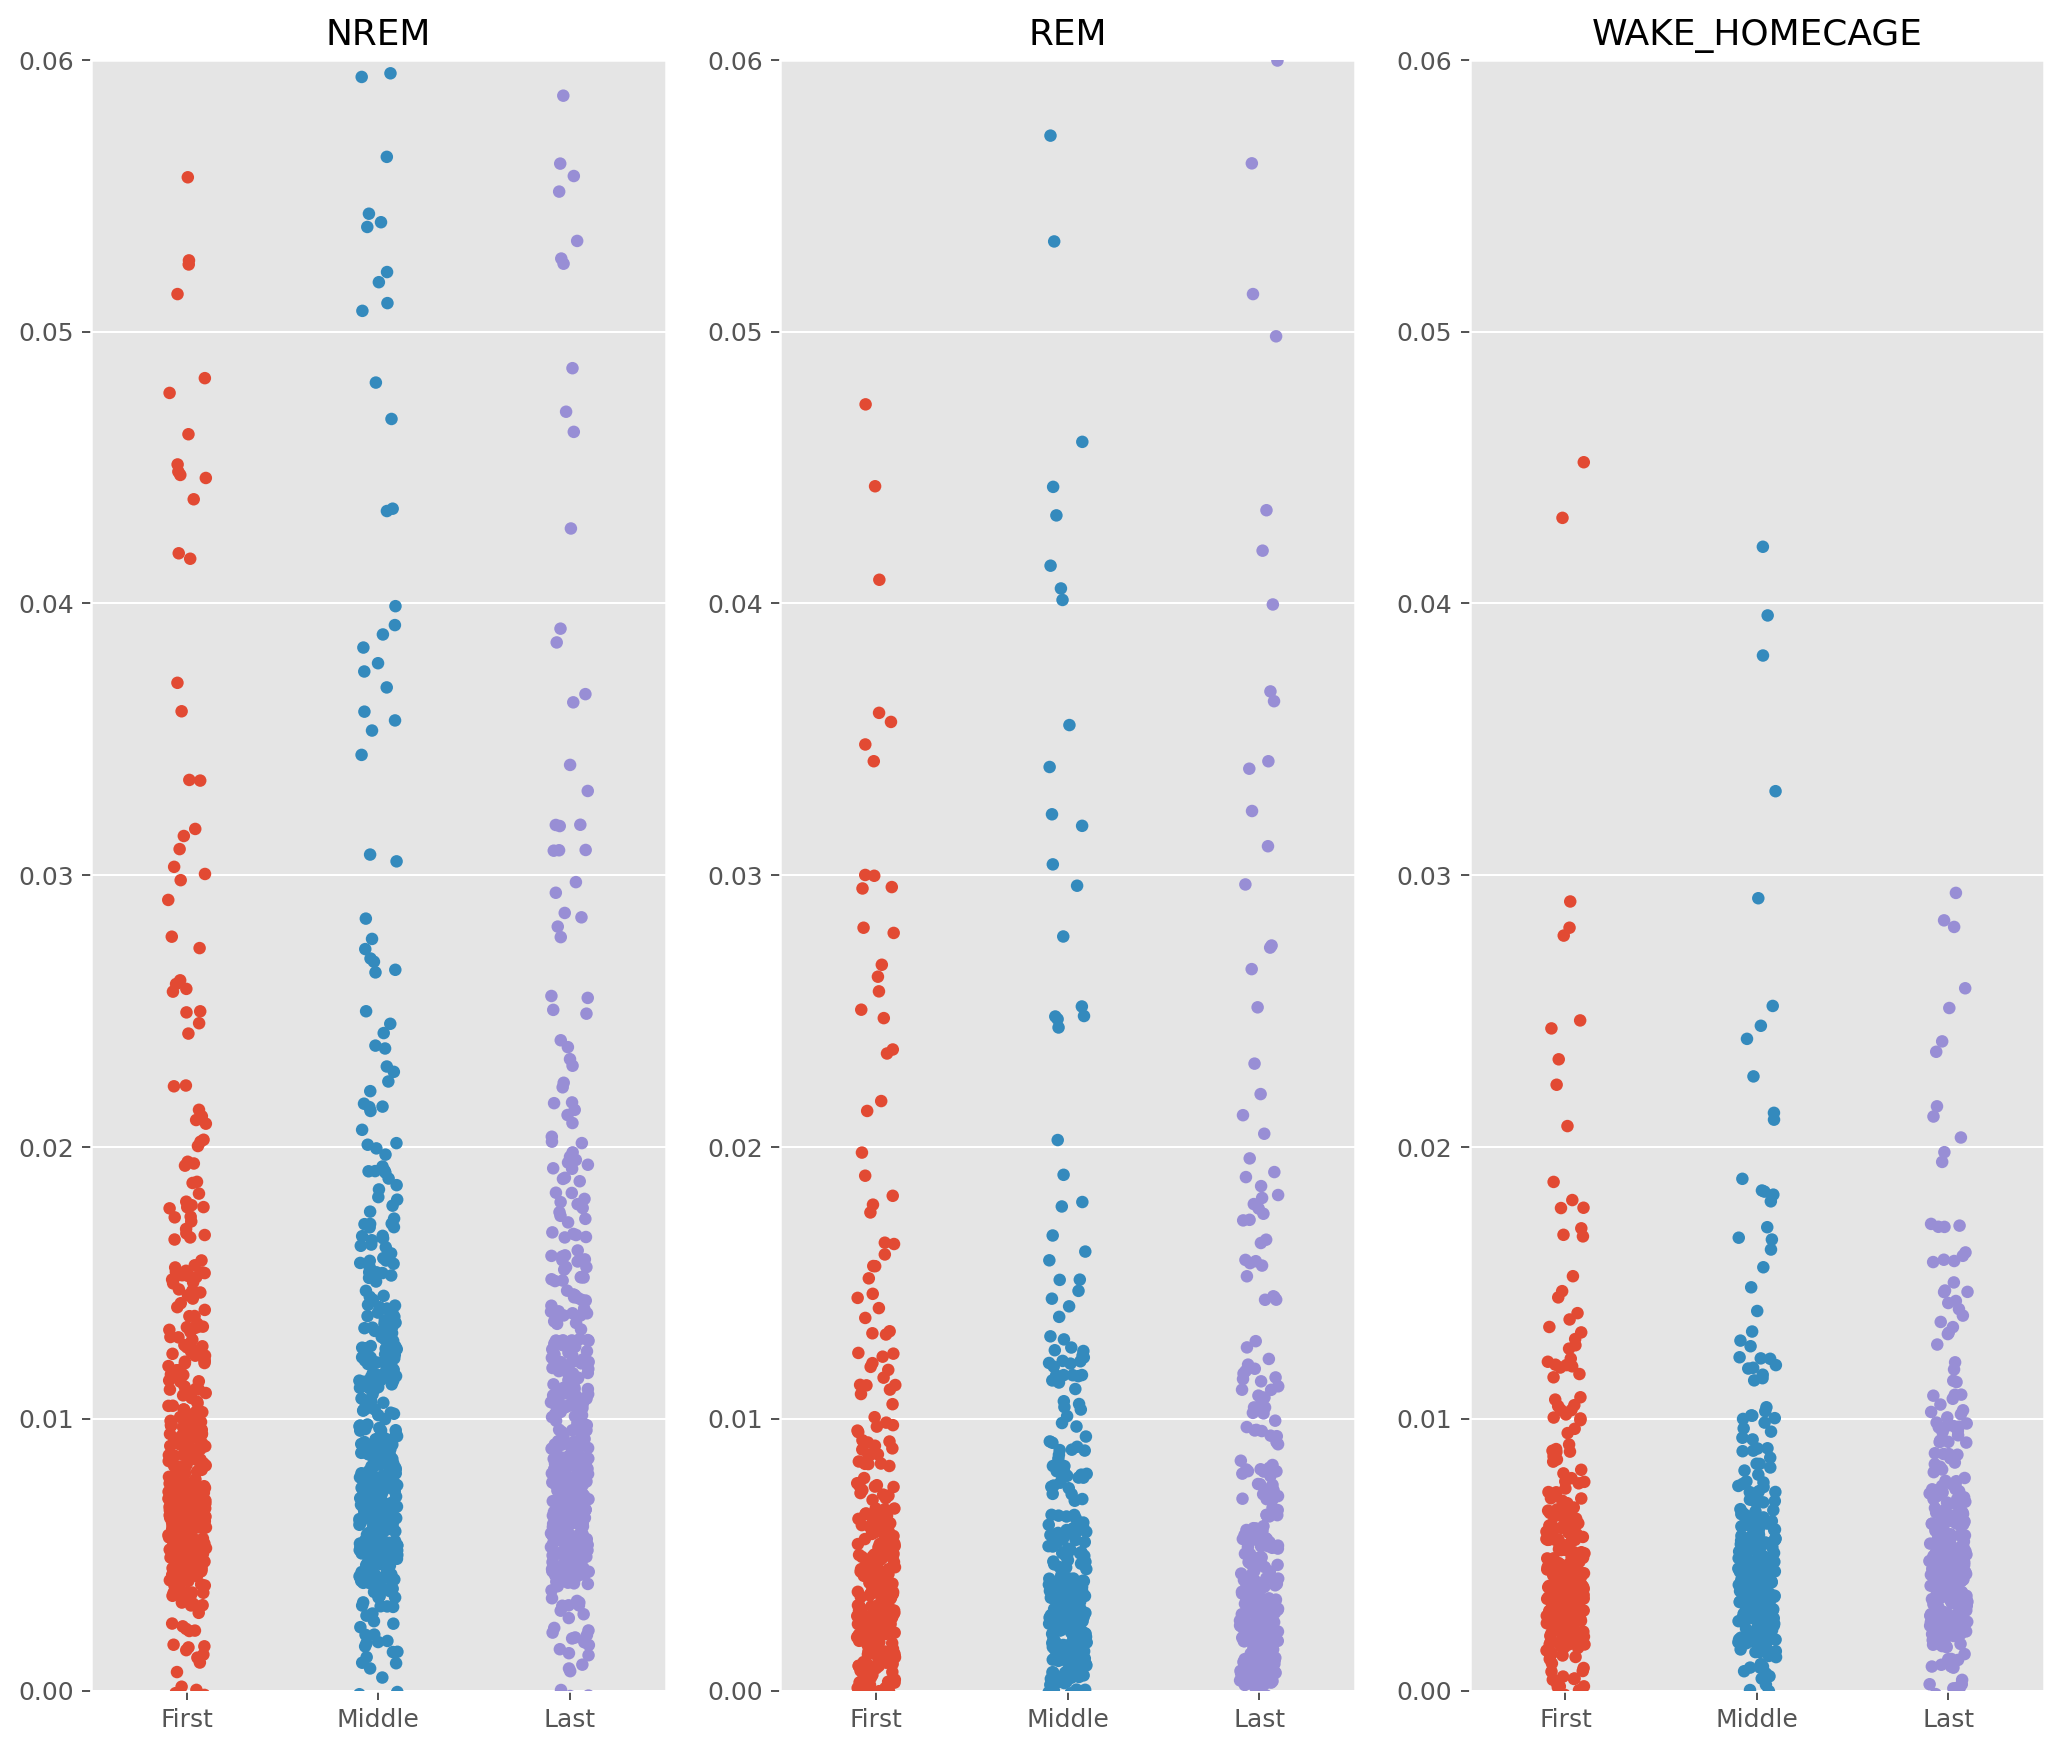

In [11]:
fig,ax = plt.subplots(1,3,dpi = 180, figsize = (14,12))

states = ['NREM','REM','WAKE_HOMECAGE']
for i,state in enumerate(states):
    y = merge(batch)[state]
    df = pd.DataFrame(y,columns=['First','Middle','Last'])
    print(scipy.stats.ttest_rel(y[:,0],y[:,2]))

    sns.stripplot(data = df,ax = ax[i])
    ax[i].set_ylim(0,0.06)
    ax[i].set_title(state)

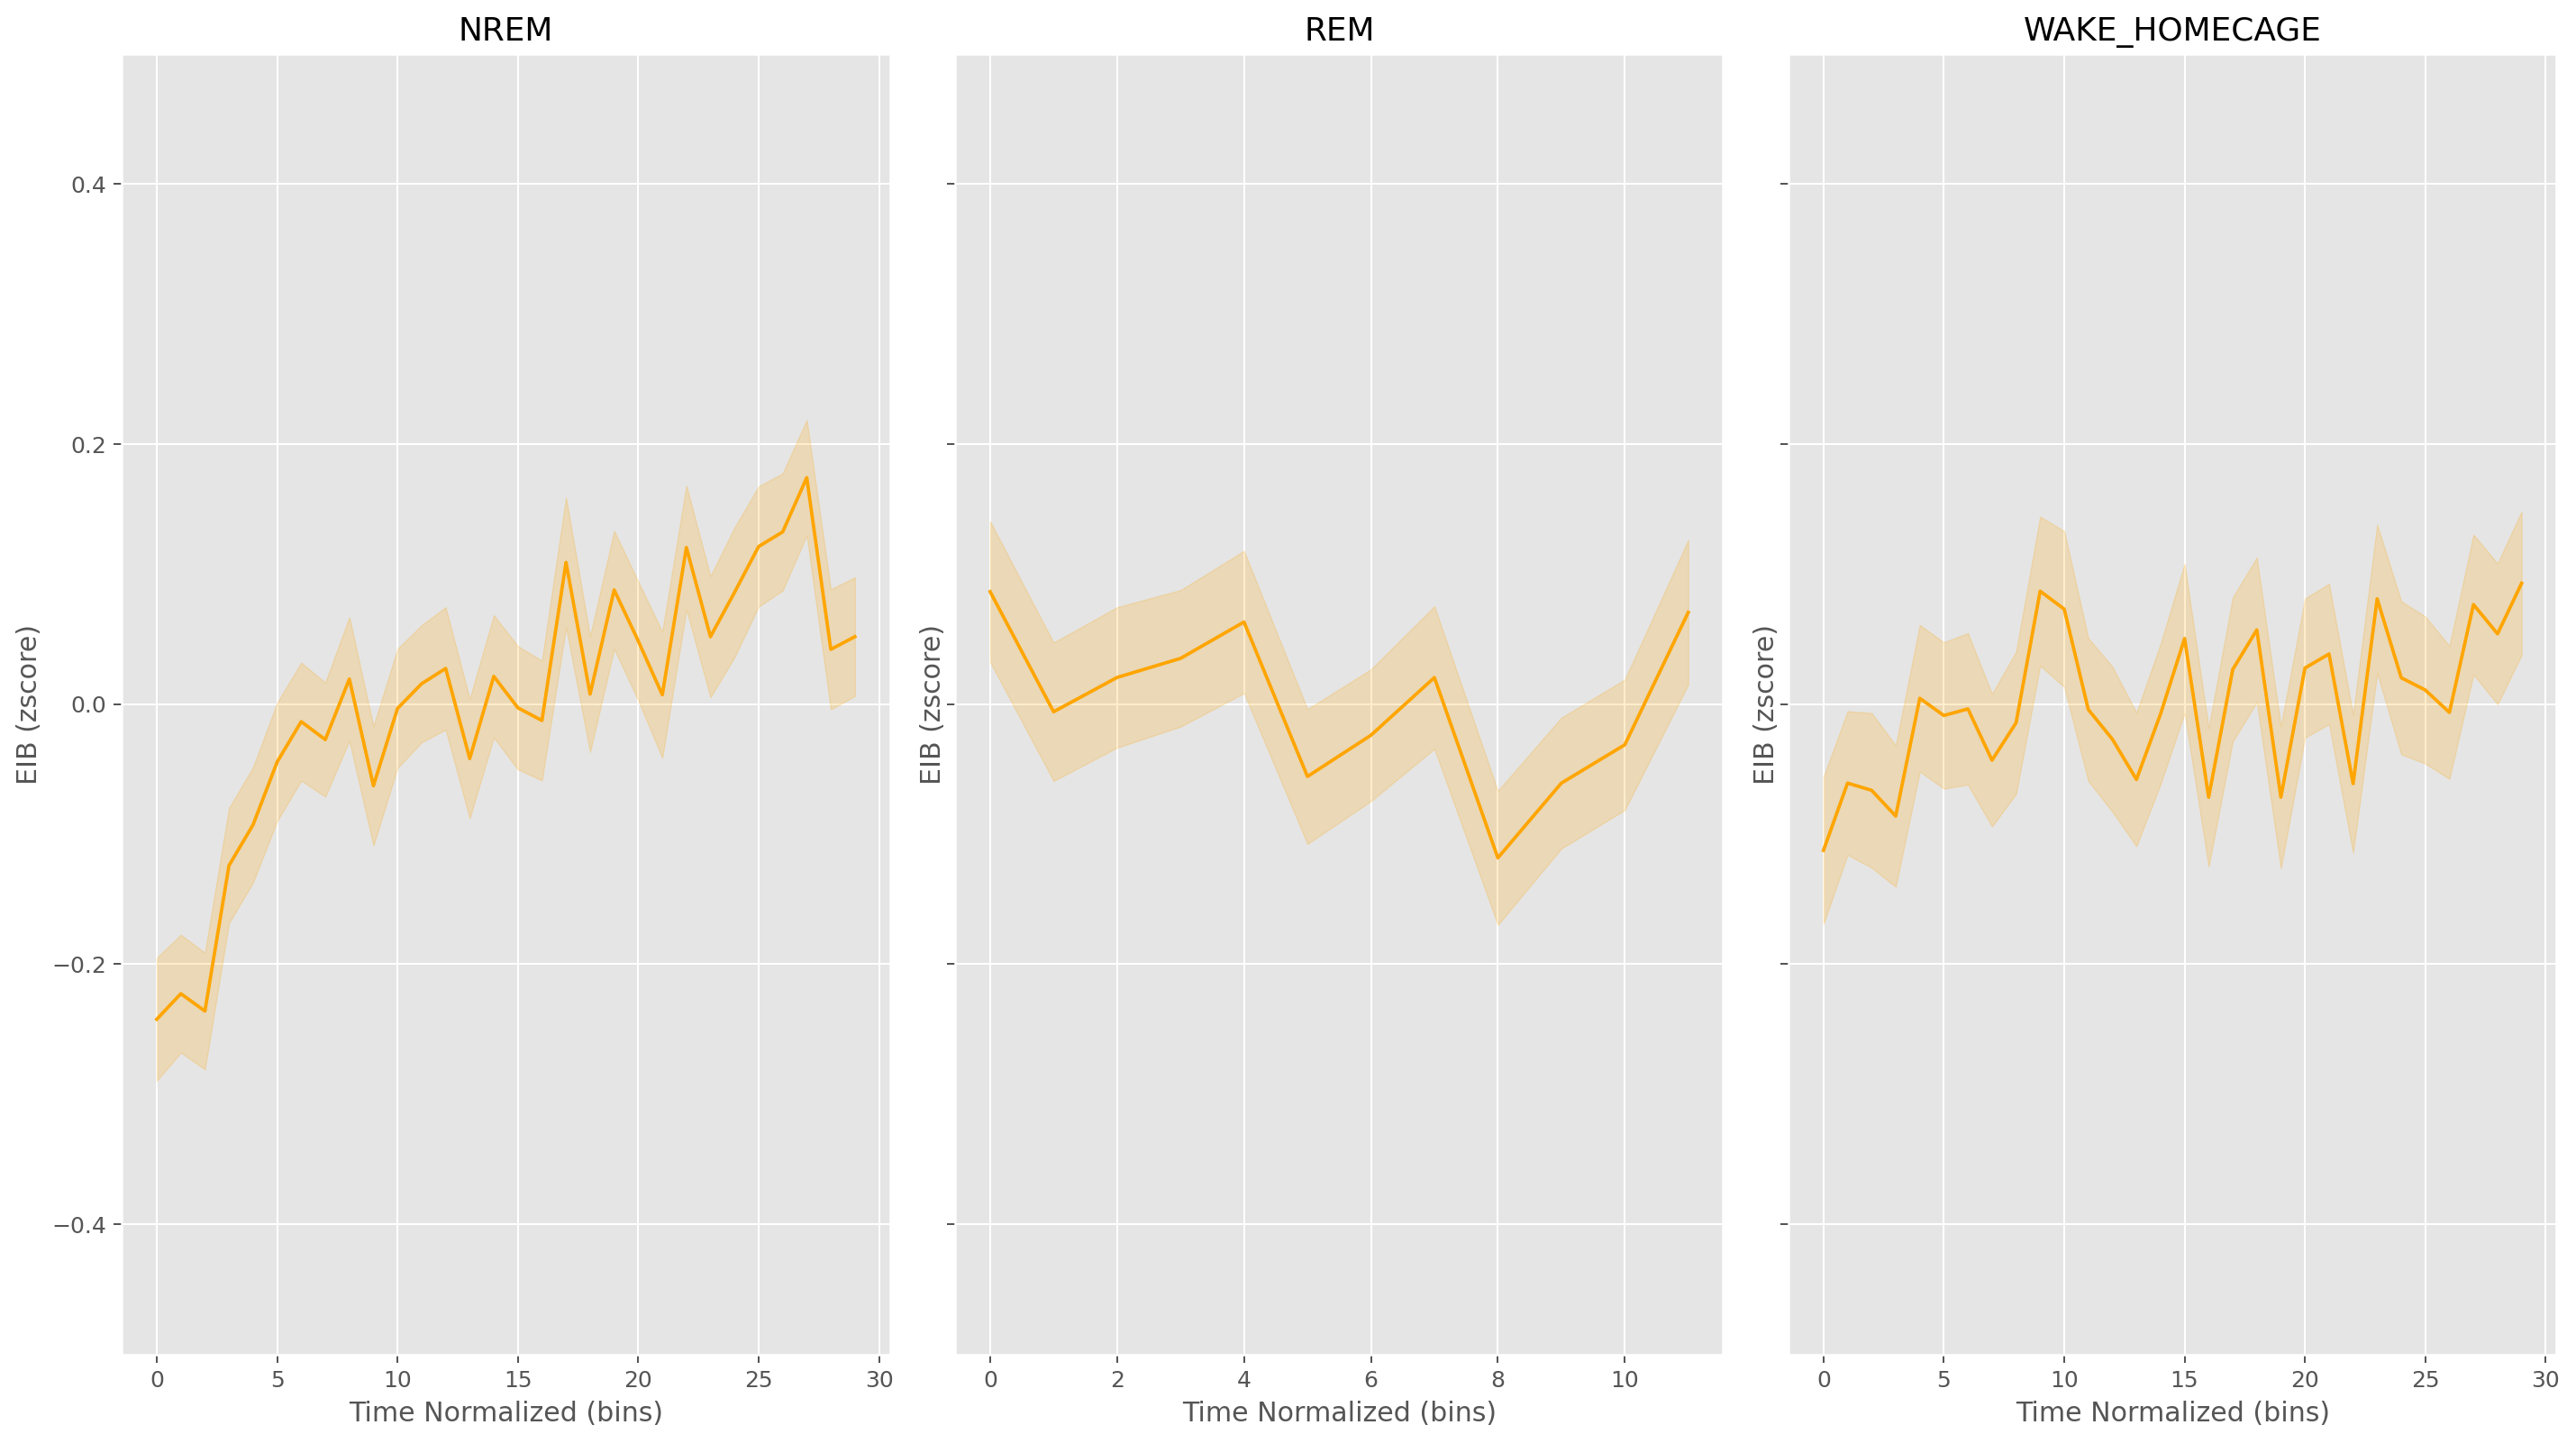

In [13]:
fig,ax = plt.subplots(1,3,dpi = 180,sharey=True,figsize = (16,9))
for i,state in enumerate(['NREM','REM','WAKE_HOMECAGE']):
    y = merge(batch)[state]
    bk.plot.curve_and_shades(range(y.shape[1]),y,'sem',ax=ax[i])
    ax[i].set_title(state)
    ax[i].set_ylim(-0.5,0.5)
    ax[i].set_xlabel('Time Normalized (bins)')
    ax[i].set_ylabel('EIB (zscore)')
plt.tight_layout()

In [89]:
def main(base_folder,local_path,*args,**kwargs):
    save = kwargs['save']
    binSize = kwargs['binSize']

    bk.load.current_session_linux(base_folder,local_path)
    states = bk.load.states(True)
    states.pop('drowsy')
    states.pop('wake')
    neurons, metadata = bk.load.spikes()
    # actmat = bk.compute.binSpikes(neurons,binSize,as_Tsd=True)

    sync = {}
    for stru in np.unique(metadata.Region):
        if len(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')])<25: continue
        if stru not in sync.keys(): sync[stru] = {}
        for state, intervals in states.items():
            sync[stru].update({state:[]})
            for inter in bk.compute.intervals_to_list_of_intervals(intervals):
                if inter.duration('s') < 50: continue
                sync[stru][state].append(synchrony(neurons, stru, 'Pyr', metadata, binSize=binSize,restrict=inter))
    

    for stru in sync:
        sync[stru] = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in sync[stru].items() ]))
    return sync

In [90]:
def merge(batch):
    all_df = {}
    for sess,b in batch.items():
        for stru,df in b.items():
            if stru not in all_df.keys(): all_df[stru] = []
            df['Name'] = sess
            all_df[stru].append(df)
    for stru in all_df:
        all_df[stru] = pd.concat(all_df[stru])
    return all_df

def plot_swarm(all_df,stru,binSize,save):
    binSize_ms = binSize * 1000
    plt.figure(figsize=(16,16),dpi = 300)
    sns.swarmplot(data = all_df[stru],alpha = 1,size = 5)
    plt.ylim(0,0.10)
    plt.title(f'BLA Sync {binSize_ms}ms bins')
    plt.ylabel('Synchrony (Average Pairwise correlation)')

    if save: plt.savefig(f'/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/Syncrony/sync-{binSize_ms}ms.svg')

In [91]:
kwargs = {'save': False,
          'binSize': 0.100}
# main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
batch,metadata = bk.load.batch(main,**kwargs)

100%|██████████| 61/61 [07:15<00:00,  7.14s/it]

Batch finished in 435.68199706077576
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat11-20150402', 'Rat11-20150403']
11.475409836065573 %


In [115]:
df = main(bk.load.base,'Rat09/Rat09-20140324',**kwargs)

Rat : 9 on day : 1
Working with session Rat09-20140324 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat09/Rat09-20140324
Data already saved in Numpy format, loading them from here:
Rat09-20140324-neurons.npy
Rat09-20140324-metadata.npy


/home/billel/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/billel/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [117]:
df['BLA']

,WAKE_HOMECAGE,NREM,REM
0,0.004653,0.008847,0.009035
1,0.004009,0.007754,0.013722
2,0.006257,0.011099,0.002758
3,0.006239,0.019620,0.012925
4,0.007557,0.018487,0.008498
5,0.008796,0.018067,0.007125
6,0.014021,0.017428,0.008831
7,0.012532,0.014572,0.010560
8,0.008453,0.016897,0.005734
9,0.003080,0.015668,0.014484


In [113]:
a = all_df['BLA']
a = a[['WAKE_HOMECAGE','Name']].dropna()

In [114]:
a.to_csv('/home/billel/Documents/sync2.csv')

(-0.04, 0.06)

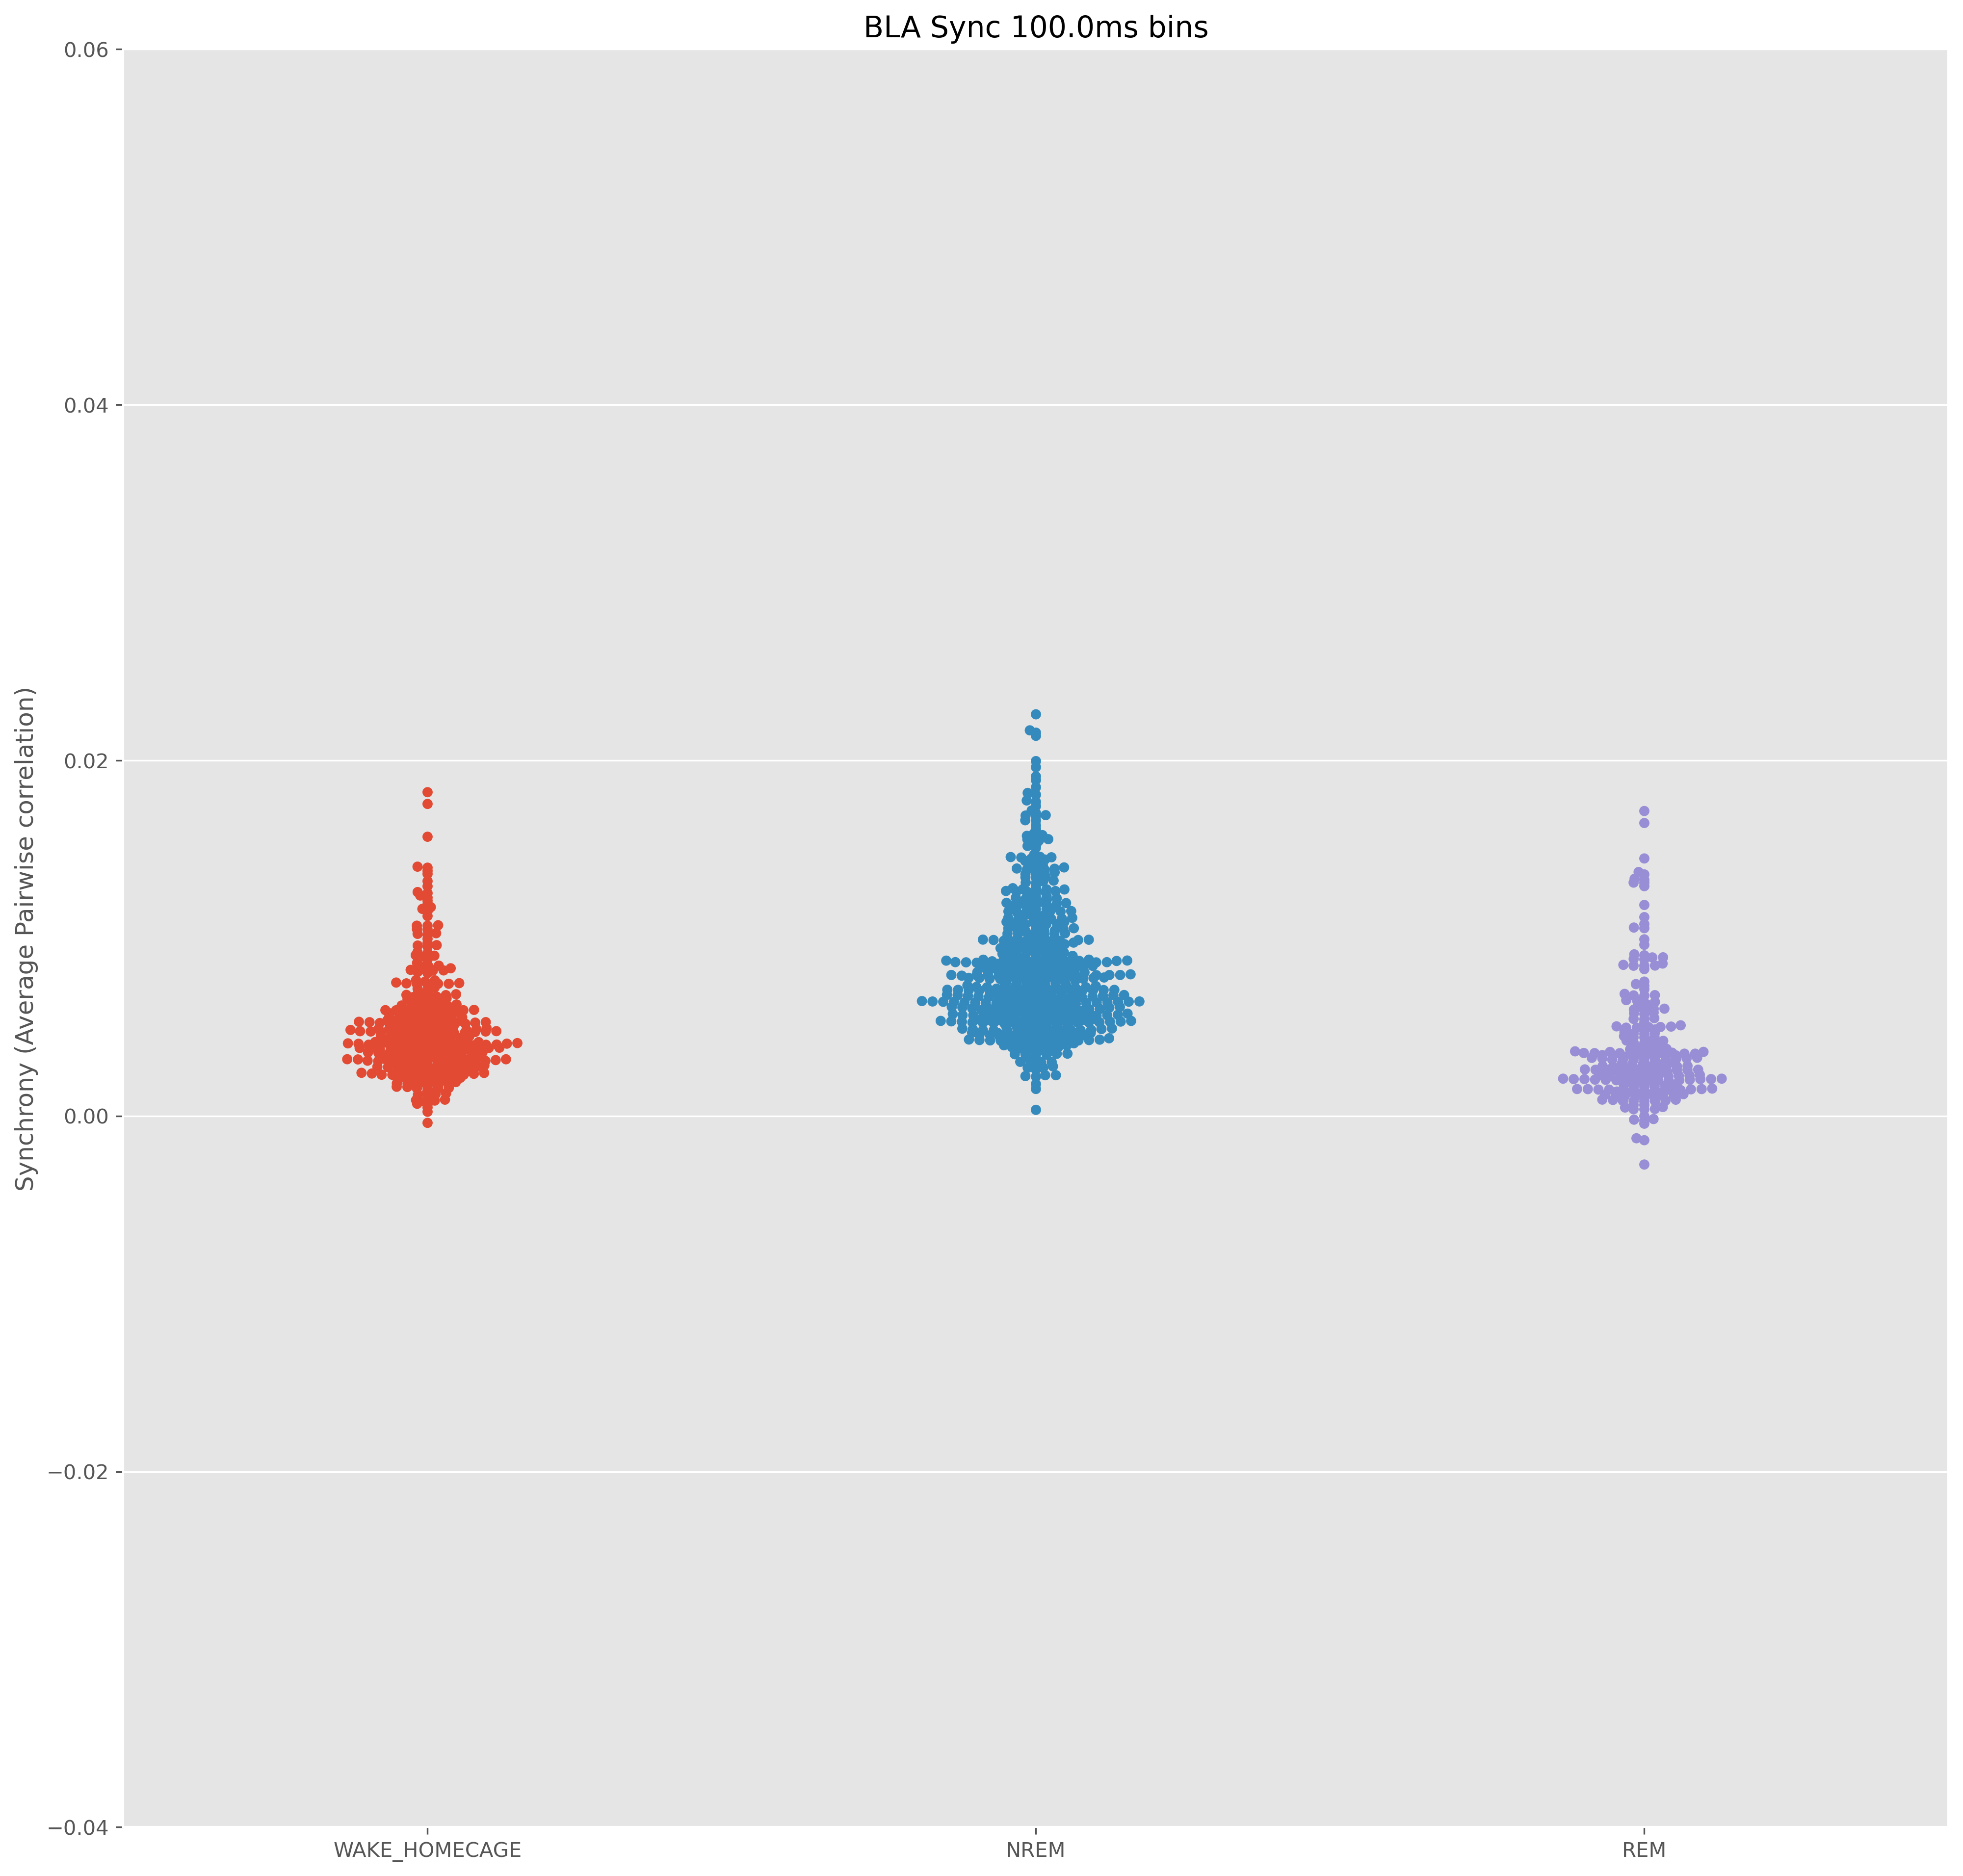

In [92]:
all_df = merge(batch)
plot_swarm(all_df,'BLA',kwargs['binSize'],True)
plt.ylim(-0.04,0.06)

In [24]:
from scipy.stats import mannwhitneyu

stru = 'Hpc'
mannwhitneyu(all_df[stru]['Rem'].dropna(),all_df[stru]['sws'].dropna())

MannwhitneyuResult(statistic=15245.0, pvalue=7.924467556885806e-34)

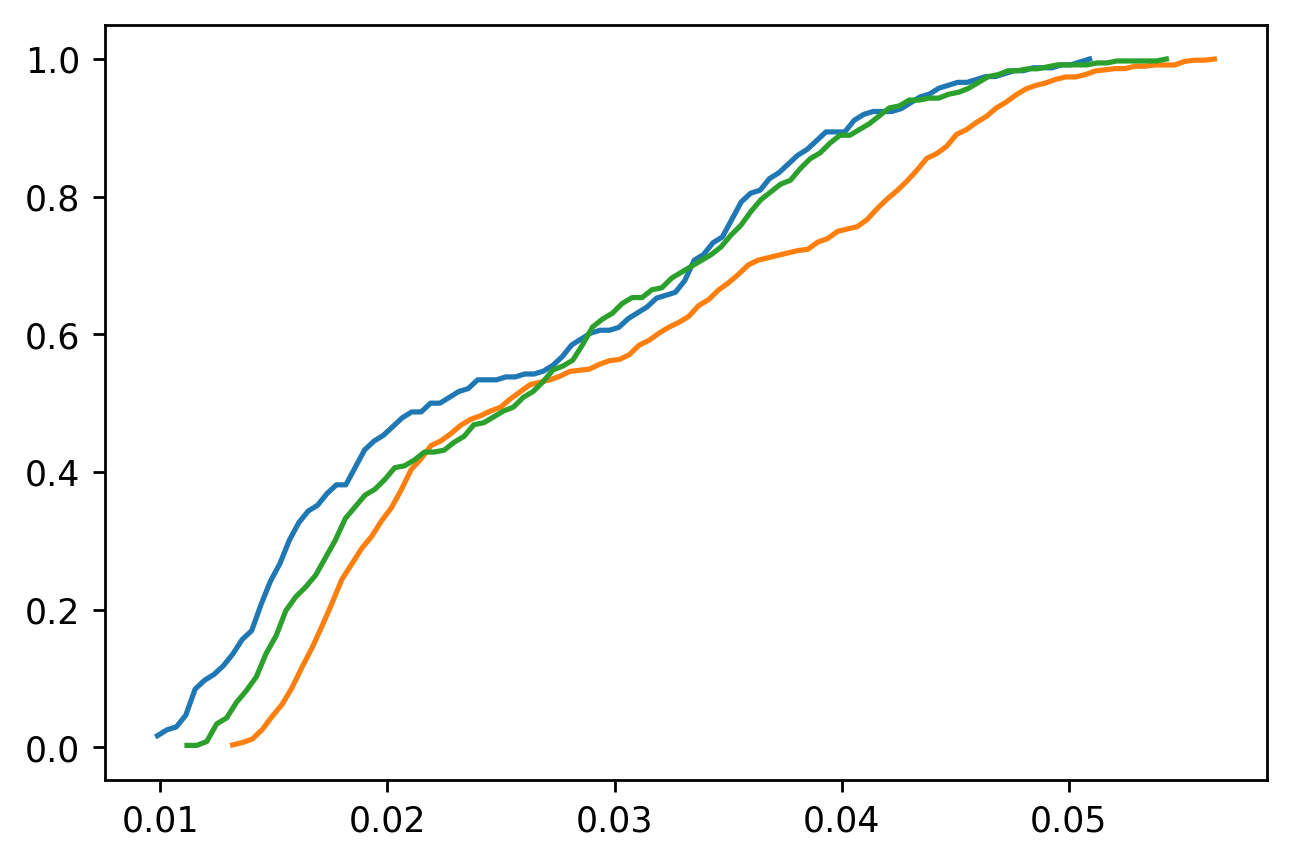

In [11]:
fig,ax = plt.subplots(1,1,dpi = 250)
bk.plot.cumsum_curves(all_df['BLA']['Rem'].dropna(),100,ax = ax)
bk.plot.cumsum_curves(all_df['BLA']['sws'].dropna(),100,ax = ax)
bk.plot.cumsum_curves(all_df['BLA']['wake_homecage'].dropna(),100,ax = ax)

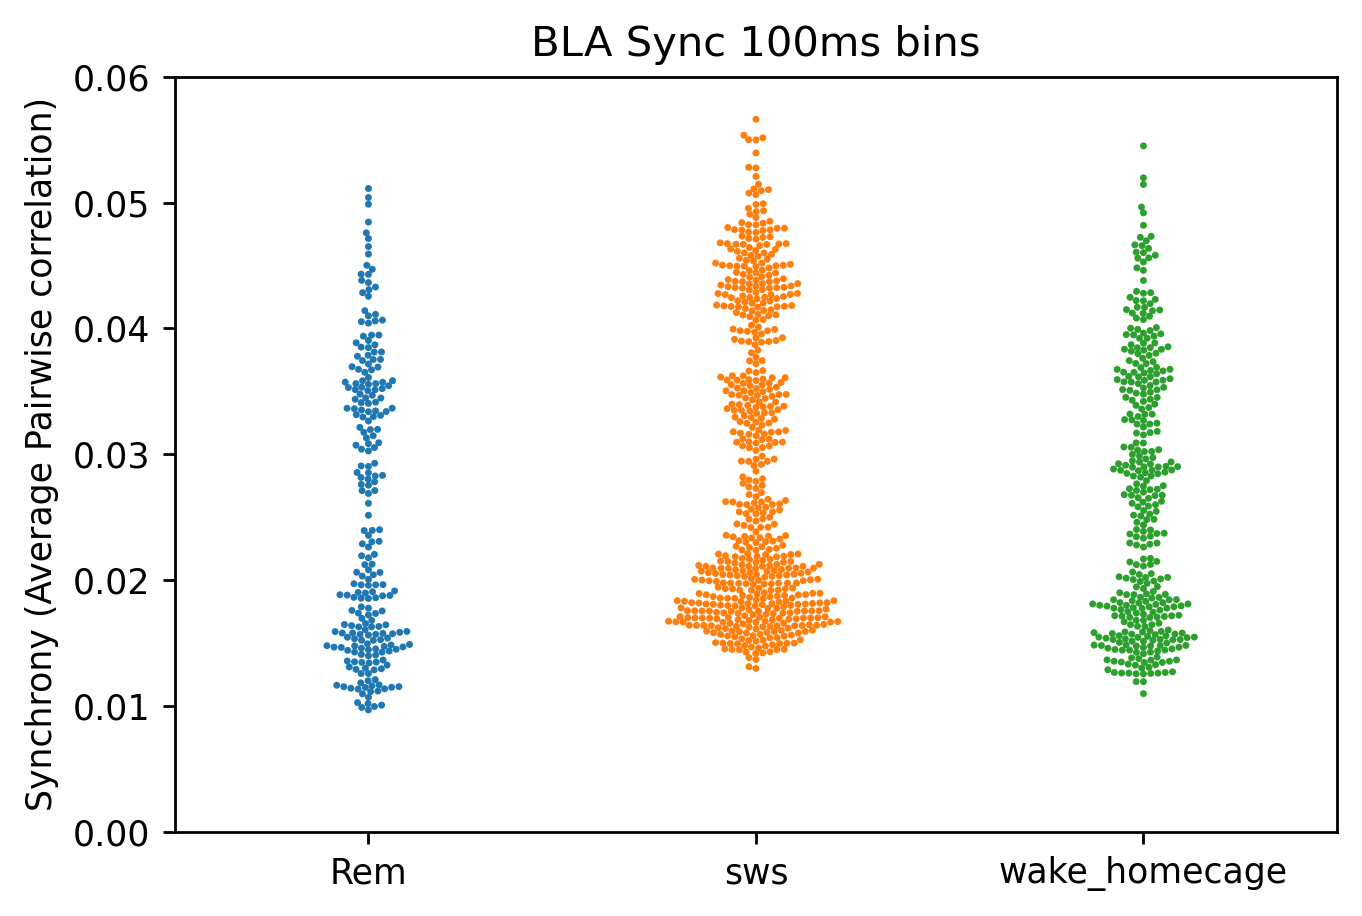

### Synchrony during or outside gamma_burst

In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os

plt.rcParams['svg.fonttype'] = 'none'

In [2]:
def synchrony(neurons, binSize, restrict=None):
    neurons = np.copy(neurons)
    if restrict is not None:
        for i, n in enumerate(neurons):
            neurons[i] = n.restrict(restrict)

    if binSize == 'IntervalSize':
        actmat = bk.compute.bin_by_intervals(neurons, restrict, as_Tsd=True)
    else:
        actmat = bk.compute.binSpikes(neurons, binSize, as_Tsd=True)

    if restrict is not None:
        actmat = actmat.restrict(restrict)
    corr = np.corrcoef(actmat, rowvar=False)
    # corr = filter_corr_matrix(corr,region,types,metadata)

    return np.nanmean(corr)


In [27]:
bk.load.current_session_linux()

neurons, metadata = bk.load.spikes()
metadata = bk.load.metadata_with_side(metadata)

states = bk.load.states()
gamma_intervals,gamma_peaks = bk.load.analysis('Gamma/gamma_intervals_nrem.npy')

no_gamma_intervals = {}
for side in ['left','right']:
    no_gamma_intervals.update({side:states['sws'].set_diff(gamma_intervals[side])})

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


In [4]:
%matplotlib qt
bk.plot.intervals(gamma_intervals['left'],'red')
bk.plot.intervals(no_gamma_intervals['left'],'green')

In [40]:



print(synchrony(neurons[(metadata.Region == 'BLA') & (metadata.Type == 'Int') & (
    metadata.Side == 'left')],'IntervalSize', gamma_intervals['left']))


print(synchrony(neurons[(metadata.Region == 'BLA') & (metadata.Type == 'Int') & (
    metadata.Side == 'left')], .035, no_gamma_intervals['left']))



0.2129706978787162
0.20382129482851824
